In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from pathlib import Path
from PIL import Image

#function of augmentation
def augmentation(img_path,basename):
    datagen = ImageDataGenerator(
        rotation_range = 10,
        shear_range = 0.0001,
        zoom_range = 0.0001,
        horizontal_flip = True,
        brightness_range = (0.01, 1))

    # Loading a sample image
    img = load_img(img_path)
    # Converting the input sample image to an array
    x = img_to_array(img)
    # Reshaping the input image
    x = x.reshape((1, ) + x.shape)




In [ ]:
# folder path
dir_path = r'/content/drive/MyDrive/CSE299/Brain_Stroke_CT-SCAN_image/Normal'
img_path = []
#get all the path of images
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        img_path.append(dir_path+path)
# print(img_path)
print("The numbers of image in the folder are :",len(img_path))



The numbers of image in the folder are : 8813


In [ ]:
# folder path
dir_path = r'/content/drive/MyDrive/CSE299/Brain_Stroke_CT-SCAN_image/Stroke'
img_path = []
#get all the path of images
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        img_path.append(dir_path+path)
# print(img_path)
print("The numbers of image in the folder are :",len(img_path))


The numbers of image in the folder are : 6050


In [ ]:
## Data Load

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.model_selection import train_test_split
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

def get_features(data_path):
  img_size = (64, 64)
  images = []
  labels = []
  for subdir in os.listdir(data_path):
      subdir_path = os.path.join(data_path, subdir)
      for file_name in os.listdir(subdir_path):
          file_path = os.path.join(subdir_path, file_name)
          img = cv2.imread(file_path)
          img = cv2.resize(img, img_size)

          if img is None:
              print(f"Unable to load image {file_path}")
              continue
          images.append(img)
          labels.append(subdir)

  return images,labels

def image_data_load(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(images, labels, test_size=0.2, random_state=42)
    return X_train_img, X_test_img, y_train_img, y_test_img

def evaluate_model(model, X_test, y_test_encoded):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("Classification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=unique_labels))

    conf_matrix = confusion_matrix(y_test_encoded, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    n_classes = len(unique_labels)

    # ROC Curve
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_encoded == i, y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    lw = 2
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=lw, label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {unique_labels[i]}')

    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, pr_auc = dict(), dict(), dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_encoded == i, y_pred_probs[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    plt.figure()
    lw = 2
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=lw, label=f'PR curve (area = {pr_auc[i]:0.2f}) for class {unique_labels[i]}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()



In [ ]:
## Define Models

In [ ]:
def model_training(name,X_train_img, X_test_img, y_train_img, y_test_img, epoch,):

    # Use LabelEncoder to convert string labels to integers
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_img)
    y_test_encoded = label_encoder.transform(y_test_img)
    num_classes = len(np.unique(y_train_encoded))
    y_train_one_hot = to_categorical(y_train_encoded, num_classes)
    y_test_one_hot = to_categorical(y_test_encoded, num_classes)
    if (name == "vgg16"):
        print("Training Start with vgg16_model")
        training_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


    # Freeze all layers of the pre-trained model
    for layer in training_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(training_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(
                              monitor="val_loss",
                              min_delta = 0.0001,
                              patience = 20,
                              restore_best_weights = True)

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_generator = train_datagen.flow(X_train_img, y_train_one_hot, batch_size=32)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = test_datagen.flow(X_test_img, y_test_one_hot, batch_size=32)
    training = model.fit(train_generator, epochs=epoch, validation_data=test_generator,callbacks = [early_stopping],)
#     accuracy = model.evaluate(test_generator)
    return training, model, y_test_encoded


In [ ]:
data_path = "/content/drive/MyDrive/CSE299/Brain_Stroke_CT-SCAN_image"
images,labels = get_features(data_path)
unique_labels = np.unique(labels)
print(unique_labels)

['Normal' 'Stroke']


In [ ]:
epoch = 50
X_train_img, X_test_img, y_train_img, y_test_img = image_data_load(images, labels)
vgg16, vgg_model,y_test_encoded = model_training("vgg16",X_train_img, X_test_img, y_train_img, y_test_img, epoch)

Training Start with vgg16_model
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
372/372 [==============================] - 18s 23ms/step - loss: 1.0508 - accuracy: 0.7359 - val_loss: 0.4665 - val_accuracy: 0.8079
Epoch 2/50
372/372 [==============================] - 7s 20ms/step - loss: 0.3443 - accuracy: 0.8548 - val_loss: 0.3228 - val_accuracy: 0.8621
Epoch 3/50
372/372 [==============================] - 8s 20ms/step - loss: 0.2409 - accuracy: 0.8973 - val_loss: 0.2714 - val_accuracy: 0.8927
Epoch 4/50
372/372 [==============================] - 7s 19ms/step - loss: 0.2001 - accuracy: 0.9184 - val_loss: 0.2605 - val_accuracy: 0.8910
Epoch 5/50
372/372 [==============================] - 7s 20ms/step - loss: 0.1505 - accuracy: 0.9421 - val_loss: 0.2092 - val_accuracy: 0.9162
Epoch 6/50
372/372 [==============================] - 8s 23ms/step - loss: 0.1319 - accuracy: 0.9476 - val_loss: 0.4238 - val_accuracy: 0.8490
Epoch 7/50
372/372 [========================

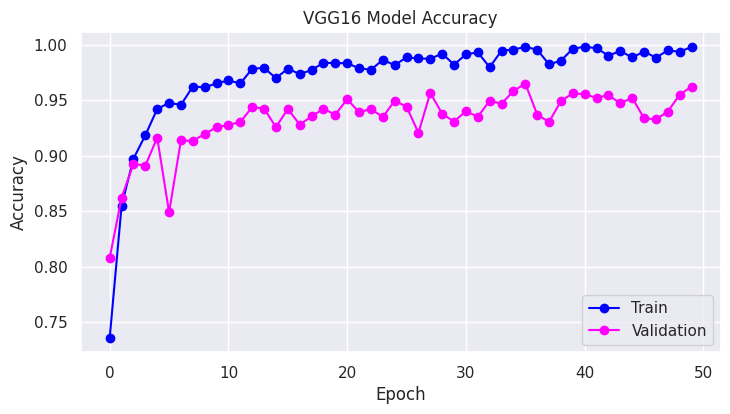

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(vgg16.history['accuracy'], 'o-',color="blue")
plt.plot(vgg16.history['val_accuracy'] ,'o-', color="magenta")
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.axis([0, 6, 0, 20])
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.show()
#plt.close()

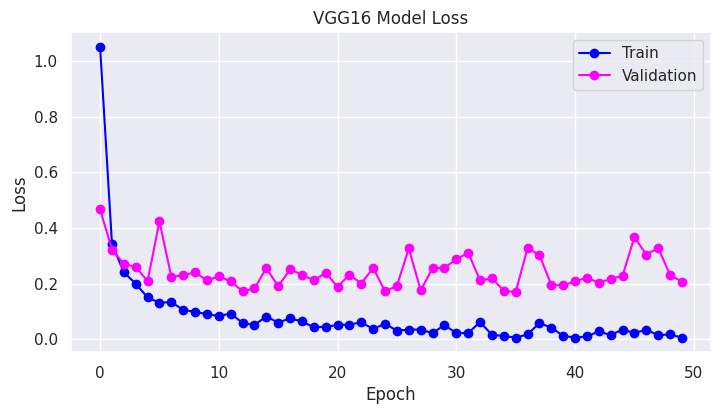

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(vgg16.history['loss'],'o-', color="blue")
plt.plot(vgg16.history['val_loss'],'o-', color="magenta")
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

93/93 [==============================] - 2s 13ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.73      0.95      0.82      1737
      Stroke       0.88      0.50      0.63      1236

    accuracy                           0.76      2973
   macro avg       0.80      0.72      0.73      2973
weighted avg       0.79      0.76      0.74      2973

Confusion Matrix:
[[1651   86]
 [ 623  613]]


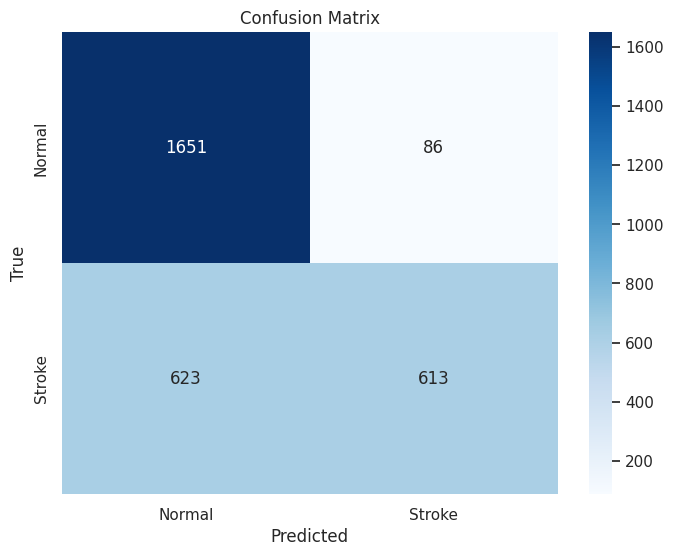

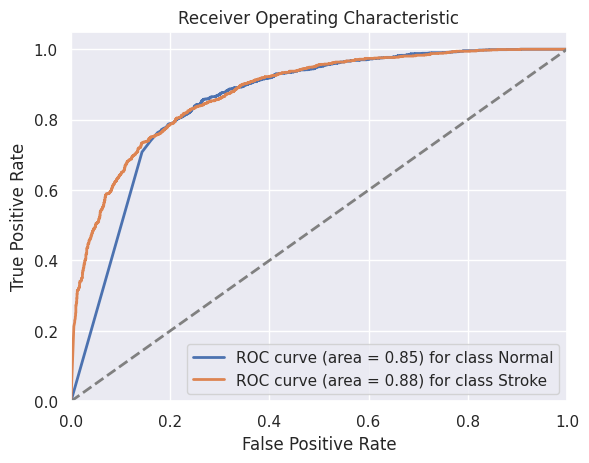

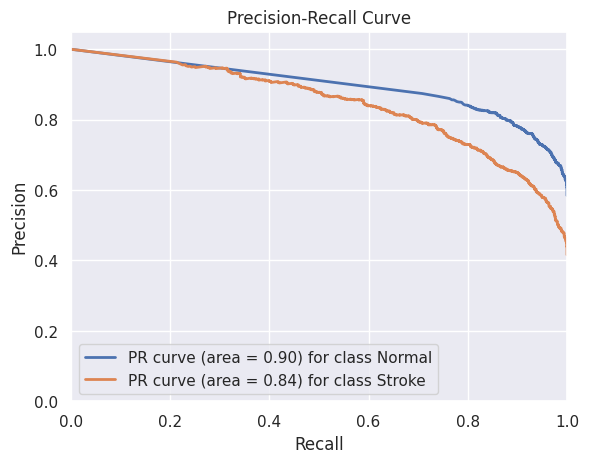

In [ ]:
evaluate_model(vgg_model, X_test_img, y_test_encoded)